# A simple example of gravity data preprocessing by detrending and filtering

钟乙源 Yiyuan Zhong

17 Aug 2025 

In [116]:
import numpy as np
import scipy as sp
from scipy.fft import fft, fft2, fftfreq, fftshift, ifftshift, ifft, ifft2
from scipy.signal import windows

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# 1 Data preparation

We use a publicly available dataset from this paper as an example: https://link.springer.com/article/10.1007/s00024-015-1182-y#article-info, which is Bouguer anomaly data of a karstic cave. Download the [dataset](https://static-content.springer.com/esm/art%3A10.1007%2Fs00024-015-1182-y/MediaObjects/24_2015_1182_MOESM1_ESM.rar) and move the file `Bouguer_field.grd` to the current directory.


Read the Bouguer gravity anomaly from the Surfer ASCII format

In [117]:
file_path = "Bouguer_field.grd"
with open(file_path, "r") as f:
    # skip the first line
    f.readline()

    # read the second line
    nx, ny = f.readline().split()
    nx = int(nx)
    ny = int(ny)

    # third line
    xlo, xhi = f.readline().split()
    xlo = float(xlo)
    xhi = float(xhi)

    # fourth line
    ylo, yhi = f.readline().split()
    ylo = float(ylo)
    yhi = float(yhi)
    f.readline()

    # read the data
    data = []
    row = f.readline()
    while row:
        if row.strip():
            row = [float(d) for d in row.split()]
            data.append(row)

        row = f.readline()
    DATA = np.array(data)
    # origin_x = xlo
    # origin_y = ylo
    x = np.linspace(xlo, xhi, nx)  # - origin_x
    y = np.linspace(ylo, yhi, ny)  # - origin_y
    X, Y = np.meshgrid(x, y)

In [118]:
xlo

403746.0

In [119]:
X.shape

(121, 94)

In [120]:
Y

array([[5062295., 5062295., 5062295., ..., 5062295., 5062295., 5062295.],
       [5062297., 5062297., 5062297., ..., 5062297., 5062297., 5062297.],
       [5062299., 5062299., 5062299., ..., 5062299., 5062299., 5062299.],
       ...,
       [5062531., 5062531., 5062531., ..., 5062531., 5062531., 5062531.],
       [5062533., 5062533., 5062533., ..., 5062533., 5062533., 5062533.],
       [5062535., 5062535., 5062535., ..., 5062535., 5062535., 5062535.]],
      shape=(121, 94))

Because the positive z-axis points downward, we swap x and y to form a right-hand Cartesian coordinate system with x pointing northwards, y eastwards and z downwards.

In [121]:
X, Y = Y, X
nx, ny = ny, nx
origin_x, origin_y = origin_y, origin_x

In [122]:
Y.shape

(121, 94)

In [123]:
X.shape

(121, 94)

Text(0.5, 1.0, 'Bouguer anomaly (mGal)')

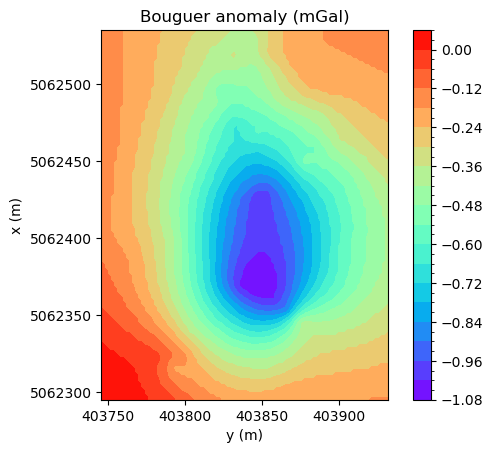

In [124]:
fig, ax = plt.subplots(1, 1)

c = ax.contourf(Y, X, DATA - (-15.93851), levels=20, cmap="rainbow")
cbar = fig.colorbar(c, ax=ax, extend="both")
ax.ticklabel_format(style="plain", scilimits=(0, 10), useOffset=False)
cbar.minorticks_on()
ax.set_aspect("equal", "box")
ax.set_xlabel("y (m)")
ax.set_ylabel("x (m)")
ax.set_title("Bouguer anomaly (mGal)")

# 2 Anomaly Isolation

Anomaly isolation divides the anomaly into a residual anomaly and a regional anomaly. We assume the regional anomaly is caused by some larger/deeper regional structures and the residual anomaly is caused by the geological structures of intrest.



For the details of the methods, refer to the following book chapter:
- *Hinze WJ, von Frese RRB, Saad AH. Appendix A Data systems processing. In: Gravity and Magnetic Exploration: Principles, Practices, and Applications. Cambridge University Press; 2013:422-476.*

## 2.1 Method 1: Trend surface analysis (detrending)

This method uses a polynomial to approximate the regional anomaly, also known as trend surface. Subtracting the trend from the anomaly, we can get the residual anomaly (局部异常).

Let's use a bilinear polynomial $g_{trend}=a_1+a_2x+a_3y+a_4xy$ as the trend surface.

$$\mathbf{g}_{trend}=\left(
    \begin{array}{cccc}
    1&x_1&y_1&x_1y_1\\
    \vdots&\vdots&\vdots&\vdots\\
    1&x_n&y_n&x_Ny_n\\
    \end{array}
    \right)
    \left(
    \begin{array}{c}
    a_1\\a_2\\a_3\\a_4
    \end{array}
    \right)=\mathbf{C}\mathbf{a}$$
where $\mathbf{a}=(a_1,a_2,a_3,a_4)^T$ are the unknown parameters.

We can get the parameters $\mathbf{a}$ by solving
$$\argmin \|\mathbf{\mathbf{C}\mathbf{a}-\mathbf{d}_{obs}}\|_2^2$$

which is equivalent to solving the system of equations 
$$(\mathbf{C}^T\mathbf{C})\mathbf{a}=\mathbf{C}^T\mathbf{d}_{obs}$$

In [125]:
# reshape the coodinates and the data from matrices into vectors
xx = X.flatten()
yy = Y.flatten()
dd = DATA.flatten()

# construct the coefficent matrix
C = np.zeros((len(dd), 4))
C[:, 0] = 1
C[:, 1] = xx
C[:, 2] = yy
C[:, 3] = xx * yy

# solve the system of equations C^T C a=C^T d
a = sp.linalg.solve(C.T @ C, C.T @ dd)
print(a)

[ 5.42770969e+05 -1.07114268e-01 -1.34494276e+00  2.65412703e-07]


/tmp/ipykernel_47774/519093018.py:14: LinAlgWarning: Ill-conditioned matrix (rcond=3.12588e-41): result may not be accurate.
  a = sp.linalg.solve(C.T @ C, C.T @ dd)


In [126]:
def cal_bilinear_trend(a, x, y):
    return a[0] + a[1] * x + a[2] * y + a[3] * x * y


# calculate the trend surface using the parameters
DATA_trend = cal_bilinear_trend(a, X, Y)

# Subtract the trend from the total anomaly to get the residual anomaly
DATA_detrend = DATA - DATA_trend

Text(0.5, 1.0, 'Residual anomaly')

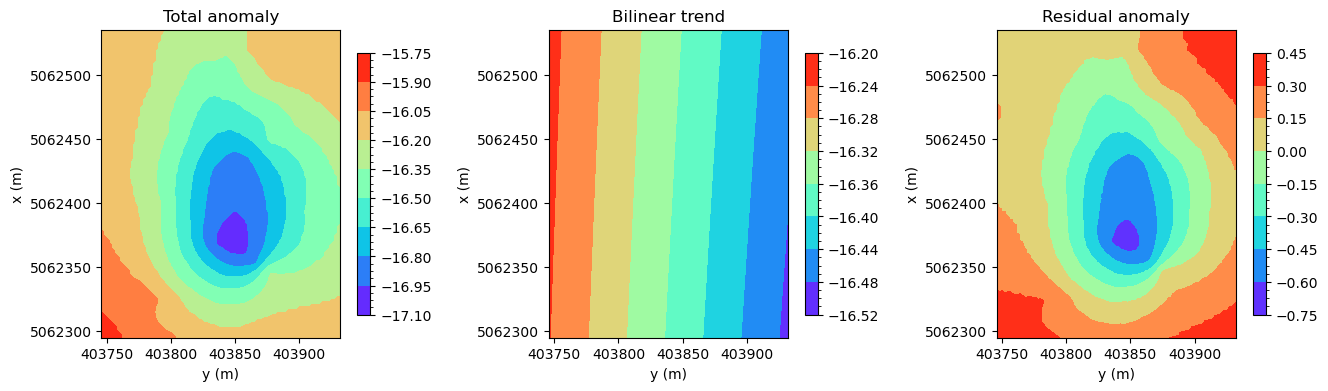

In [165]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
plt.subplots_adjust(wspace=0.3)
for i, D in enumerate([DATA, DATA_trend, DATA_detrend]):
    ax = axs[i]
    c = ax.contourf(Y, X, D, cmap="rainbow")
    cbar = fig.colorbar(c, ax=ax, shrink=0.85)
    cbar.minorticks_on()

for ax in axs:
    ax.set_aspect("equal", "box")
    ax.set_xlabel("y (m)")
    ax.set_ylabel("x (m)")
    ax.ticklabel_format(style="plain", scilimits=(0, 10), useOffset=False)

axs[0].set_title("Total anomaly")
axs[1].set_title("Bilinear trend")
axs[2].set_title("Residual anomaly")

We can also show it in a 3D view:

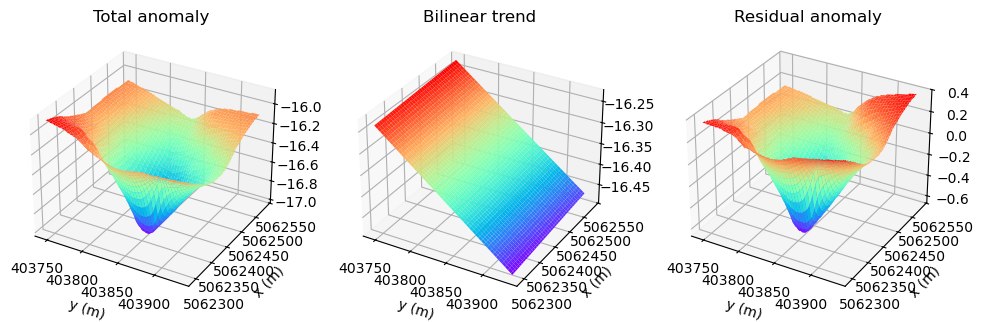

In [167]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8), subplot_kw={"projection": "3d"})
c = axs[0].plot_surface(Y, X, DATA, cmap="rainbow")
c2 = axs[1].plot_surface(Y, X, DATA_trend, cmap="rainbow")
c3 = axs[2].plot_surface(Y, X, DATA_detrend, cmap="rainbow")
axs[0].set_title("Total anomaly")
axs[1].set_title("Bilinear trend")
axs[2].set_title("Residual anomaly")

for ax in axs:
    ax.set_xlabel("y (m)")
    ax.set_ylabel("x (m)")
    ax.ticklabel_format(style="plain", scilimits=(0, 10), useOffset=False)

## 2.2 Method 2: Spectral filtering

In [168]:
SP = sp.fft.fft2(DATA)
SP = fftshift(SP)

dx = x[1] - x[0]
dy = y[1] - y[0]
xf = fftfreq(nx, dx)
yf = fftfreq(ny, dy)
# we have swapped x and y, and now x points to the north, y points to the east. When plotting a figure, we consider the new y (east) as x-axis in the figure and the new x (north) as y-axis in the figure
YF, XF = np.meshgrid(yf, xf)
XF = fftshift(XF)
YF = fftshift(YF)

Show the 2D spectrum of the original Bouguer anomay

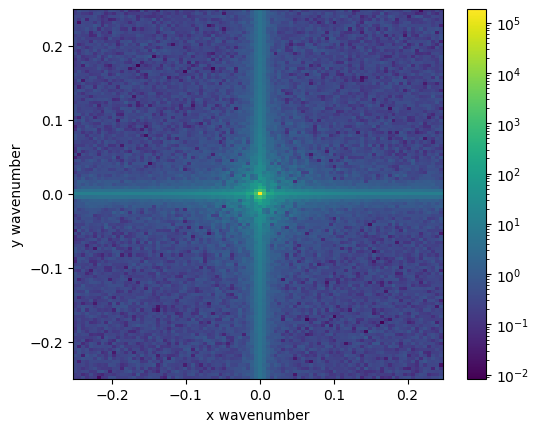

In [169]:
fig, ax = plt.subplots(1, 1)
Z = np.abs(SP)
c = ax.pcolormesh(YF, XF, Z, norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
fig.colorbar(c, ax=ax)
ax.set_xlabel("x wavenumber")
ax.set_ylabel("y wavenumber")
ax.set_aspect("equal", "box")

Make a filter in frequency domain

In [170]:
# Reference: https://newion.uwinnipeg.ca/~sliao/Courses/7205/Week07A.pdf


# filters formed by rotating a boxcar window. This filter is susceptible to Gibbs’ error.
def circular_lowpass_window(f_cut, XF, YF):
    temp = np.zeros_like(XF)
    mask = (XF**2 + YF**2) <= (f_cut**2)
    temp[mask] = 1
    return temp


def circular_banpass_window(freqmin, freqmax, XF, YF):
    temp = np.zeros_like(XF)
    mask = ((XF**2 + YF**2) >= (freqmin**2)) & ((XF**2 + YF**2) <= (freqmax**2))
    temp[mask] = 1
    return temp


# Filters with window carpentry.
# A larger n results a sharper window edge.
# Sharper windows can cause larger Gibbs’ errors, while smoother windows retain more signal energy in the rejected band.
def Butterworth_lowpass_window(f_cut, XF, YF, n=4):
    D = np.sqrt(XF**2 + YF**2)
    temp = 1 / (1 + (D / f_cut) ** (2 * n))
    return temp


def Butterworth_bandpass_window(freqmin, freqmax, XF, YF, n=4):
    D = np.sqrt(XF**2 + YF**2)
    temp1 = 1 / (1 + (D / freqmax) ** (2 * n))
    temp2 = 1 - 1 / (1 + (D / freqmin) ** (2 * n))
    return temp1 * temp2

Text(0.5, 0, 'x wavenumber')

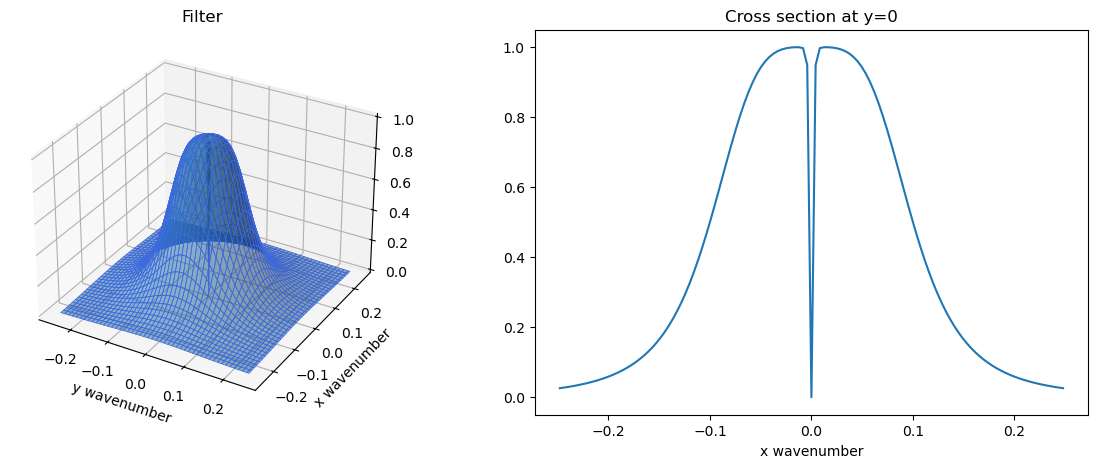

In [171]:
# You can try different valuse of n to see how the shape of the window changes

filter_win = Butterworth_bandpass_window(
    freqmin=1 / 500, freqmax=1 / 10, XF=XF, YF=YF, n=2
)
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")

surf = ax1.plot_surface(
    YF,
    XF,
    filter_win,
    linewidth=0,
    antialiased=True,
    edgecolor="royalblue",
    lw=0.5,
    alpha=0.5,
)
ax1.set_xlabel("y wavenumber")
ax1.set_ylabel("x wavenumber")
ax1.set_title("Filter")

ax2 = fig.add_subplot(1, 2, 2)
plt.subplots_adjust(wspace=0.1)
ax2.plot(XF[np.isclose(YF, 0)], filter_win[np.isclose(YF, 0)])
ax2.set_title("Cross section at y=0")
ax2.set_xlabel("x wavenumber")

Apply the filter to the data

In [172]:
# Apply the filter
SP_pass = SP * filter_win
SP_reject = SP * (1 - filter_win)

# Convert the filtered signal from spectral domain to spatial domain
DATA_pass = ifft2(ifftshift(SP_pass)).real
DATA_reject = ifft2(ifftshift(SP_reject)).real

Text(0.5, 1.0, 'Passed signal')

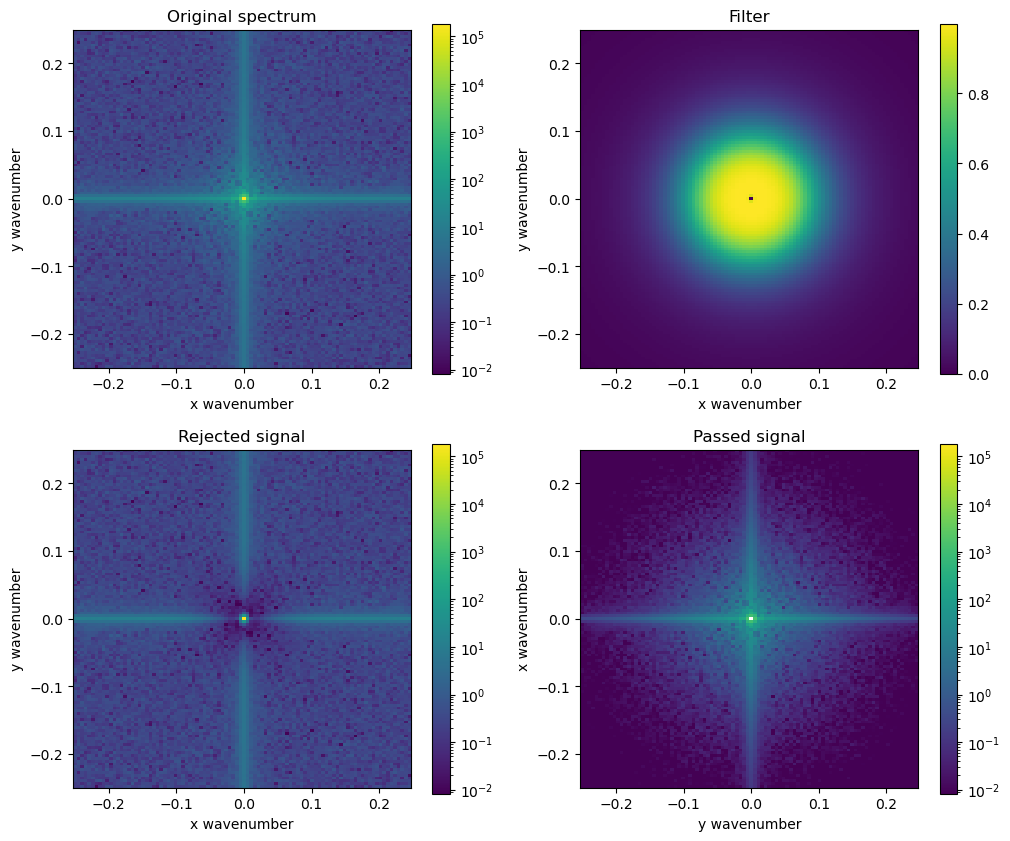

In [173]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

c = axs[0][0].pcolormesh(YF, XF, np.abs(SP), norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
fig.colorbar(c, ax=axs[0][0])
axs[0][0].set_xlabel("x wavenumber")
axs[0][0].set_ylabel("y wavenumber")
axs[0][0].set_aspect("equal", "box")
axs[0][0].set_title("Original spectrum")

c = axs[0][1].pcolormesh(YF, XF, filter_win)
fig.colorbar(c, ax=axs[0][1])
axs[0][1].set_xlabel("x wavenumber")
axs[0][1].set_ylabel("y wavenumber")
axs[0][1].set_aspect("equal", "box")
axs[0][1].set_title("Filter")

c = axs[1][0].pcolormesh(
    YF, XF, np.abs(SP_reject), norm=LogNorm(vmin=Z.min(), vmax=Z.max())
)
fig.colorbar(c, ax=axs[1][0])
axs[1][0].set_xlabel("x wavenumber")
axs[1][0].set_ylabel("y wavenumber")
axs[1][0].set_aspect("equal", "box")
axs[1][0].set_title("Rejected signal")

c = axs[1][1].pcolormesh(
    YF, XF, np.abs(SP_pass), norm=LogNorm(vmin=Z.min(), vmax=Z.max())
)
fig.colorbar(c, ax=axs[1][1])
axs[1][1].set_xlabel("y wavenumber")
axs[1][1].set_ylabel("x wavenumber")
axs[1][1].set_aspect("equal", "box")
axs[1][1].set_title("Passed signal")

(array([4.900e+01, 3.900e+01, 5.300e+01, 3.747e+03, 7.088e+03, 2.590e+02,
        3.400e+01, 5.600e+01, 4.800e+01, 1.000e+00]),
 array([-16.44424388, -16.42328692, -16.40232995, -16.38137298,
        -16.36041602, -16.33945905, -16.31850208, -16.29754511,
        -16.27658815, -16.25563118, -16.23467421]),
 <BarContainer object of 10 artists>)

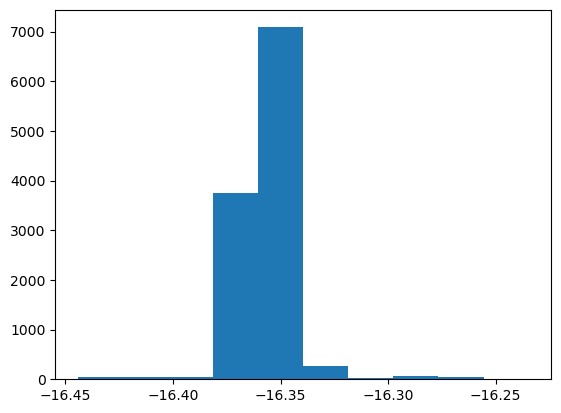

In [174]:
plt.hist(DATA_reject.flatten())

Text(0.5, 1.0, 'Residual anomaly \n(signal in the passband)')

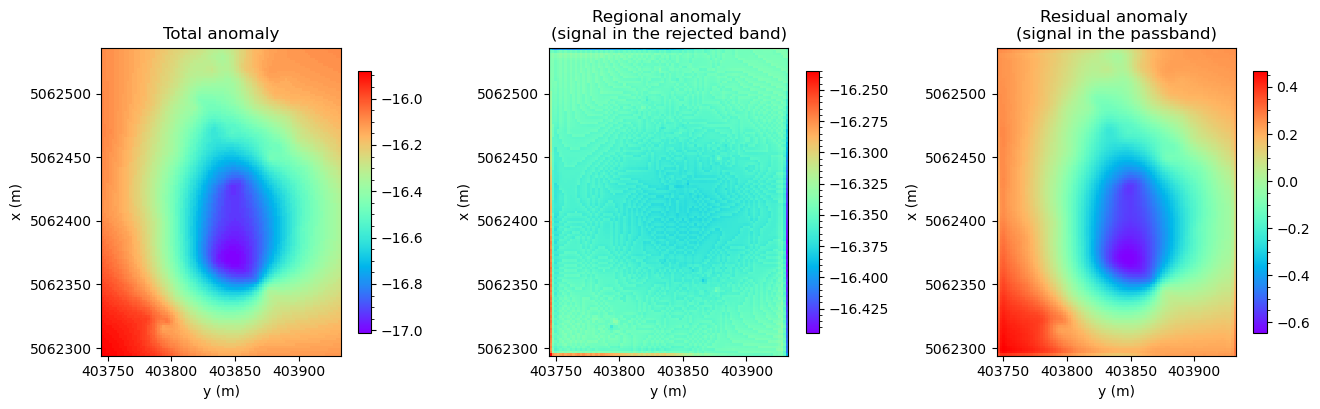

In [175]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
plt.subplots_adjust(wspace=0.3)
for i, D in enumerate([DATA, DATA_reject, DATA_pass]):
    ax = axs[i]
    c = ax.pcolormesh(Y, X, D, cmap="rainbow")
    cbar = fig.colorbar(c, ax=ax, shrink=0.85)
    cbar.minorticks_on()

for ax in axs:
    ax.set_aspect("equal", "box")
    ax.set_xlabel("y (m)")
    ax.set_ylabel("x (m)")
    ax.ticklabel_format(style="plain", scilimits=(0, 10), useOffset=False)
axs[0].set_title("Total anomaly")
axs[1].set_title("Regional anomaly \n(signal in the rejected band)")
axs[2].set_title("Residual anomaly \n(signal in the passband)")

# 3 Save the results

Save the detrended anomaly

In [176]:
# xx = X.flatten()
# yy = Y.flatten()
# dd = DATA_detrend.flatten()
# data_to_save = np.stack((xx, yy, dd)).T
# np.savetxt("Detrended_anomaly.dat", data_to_save)

Save the filtered anomaly

In [220]:
xx = X.flatten()
yy = Y.flatten()
zz = np.ones_like(xx) * (-318)
dd = DATA_pass.flatten()
data_to_save = np.stack((xx, yy, zz, dd)).T
np.savetxt("Filtered_anomaly.dat", data_to_save)

In [221]:
x_read, y_read, z_read, d_read = np.loadtxt("Filtered_anomaly.dat", unpack=True)

In [222]:
X = x_read.reshape((nx, ny))
Y = y_read.reshape((nx, ny))
D = d_read.reshape((nx, ny))

In [223]:
X.shape

(121, 94)

In [224]:
X

array([[5062295., 5062295., 5062295., ..., 5062295., 5062295., 5062295.],
       [5062297., 5062297., 5062297., ..., 5062297., 5062297., 5062297.],
       [5062299., 5062299., 5062299., ..., 5062299., 5062299., 5062299.],
       ...,
       [5062531., 5062531., 5062531., ..., 5062531., 5062531., 5062531.],
       [5062533., 5062533., 5062533., ..., 5062533., 5062533., 5062533.],
       [5062535., 5062535., 5062535., ..., 5062535., 5062535., 5062535.]],
      shape=(121, 94))

In [225]:
Y

array([[403746., 403748., 403750., ..., 403928., 403930., 403932.],
       [403746., 403748., 403750., ..., 403928., 403930., 403932.],
       [403746., 403748., 403750., ..., 403928., 403930., 403932.],
       ...,
       [403746., 403748., 403750., ..., 403928., 403930., 403932.],
       [403746., 403748., 403750., ..., 403928., 403930., 403932.],
       [403746., 403748., 403750., ..., 403928., 403930., 403932.]],
      shape=(121, 94))

In [226]:
D

array([[0.35467421, 0.39552447, 0.40172453, ..., 0.23087567, 0.24037898,
        0.28296418],
       [0.38986694, 0.44656752, 0.4567428 , ..., 0.2198253 , 0.23366433,
        0.29237694],
       [0.3959842 , 0.45733123, 0.46859389, ..., 0.21212972, 0.22720324,
        0.29097984],
       ...,
       [0.24751338, 0.24408434, 0.2384545 , ..., 0.24771801, 0.24843869,
        0.24842156],
       [0.25626015, 0.25673516, 0.25188001, ..., 0.24799581, 0.2482477 ,
        0.25147758],
       [0.29303141, 0.30899417, 0.30852153, ..., 0.242471  , 0.24600592,
        0.26408605]], shape=(121, 94))

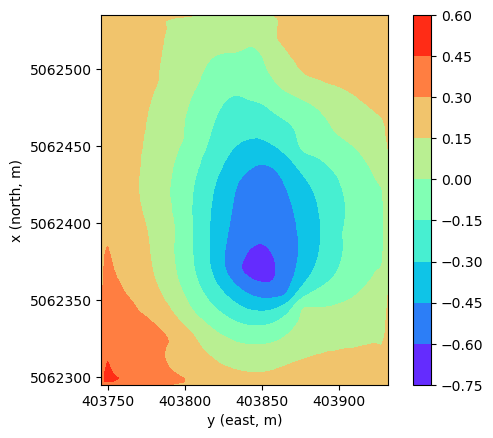

In [227]:
fig, ax = plt.subplots(1, 1)
c = ax.contourf(Y, X, D, cmap="rainbow")
plt.colorbar(c)
ax.set_aspect("equal", "box")
ax.set_xlabel("y (east, m)")
ax.set_ylabel("x (north, m)")
ax.ticklabel_format(style="plain", scilimits=(0, 10), useOffset=False)

In [207]:
0.75 * 0.05

0.037500000000000006

# Data from Pivetta and Braitenberg (2015) 

Pivetta and Braitenberg (2015). Laser-scan and gravity joint investigation for subsurface cavity exploration — The Grotta Gigante benchmark. Geophysics.

Get the data from s2.pdf in https://library.seg.org/doi/suppl/10.1190/geo2014-0601.1 . Since the data is presented in a pdf file, we need to copy it to a text file gravity_Pivetta2015.txt

In [185]:
data2 = np.loadtxt("./gravity_Pivetta2015.txt")

In [219]:
np.mean(zs)

np.float64(-318.68334666666664)

In [186]:
ys = data2[:, 0]
xs = data2[:, 1]
zs = data2[:, 2]
zs = -zs
bouguer_gz = data2[:, 4]
bouguer_gz2 = data2[:, 5]

In [187]:
# xs = xs - origin_x
# ys = ys - origin_y

In [188]:
min_x = np.min(xs)
max_x = np.max(xs)
min_y = np.min(ys)
max_y = np.max(ys)

In [189]:
print(min_x, max_x)
print(min_y, max_y)

5062295.76 5062534.34
403747.654 403931.483


In [190]:
print(min(zs), max(zs))

-322.101 -315.066


In [191]:
data_to_save_pivetta = np.stack((xs, ys, zs, bouguer_gz2)).T
np.savetxt("bouguer_gz_detrended_Pivetta2015.dat", data_to_save_pivetta)

The difference between the fifth column (data2[:, 4]) and sixth column (data2[:, 5]) is a constant value

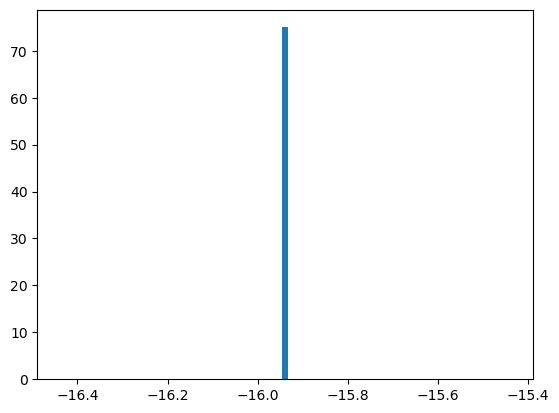

In [192]:
_ = plt.hist((bouguer_gz - bouguer_gz2).round(6), bins=75)

In [193]:
(bouguer_gz - bouguer_gz2).round(6)

array([-15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938507,
       -15.938507, -15.938507, -15.938507, -15.938507, -15.938

In [194]:
from scipy.interpolate import RBFInterpolator

xy = np.hstack((xs[:, np.newaxis], ys[:, np.newaxis]))
rbf = RBFInterpolator(xy, bouguer_gz2, neighbors=50)

Yi, Xi = np.meshgrid(np.linspace(min_y, max_y, 100), np.linspace(min_x, max_x, 100))
xy_interp = np.stack((Xi.flatten(), Yi.flatten())).T
data_i = rbf(xy_interp)
data_i = np.reshape(data_i, Xi.shape)

Text(0.5, 1.0, 'Bouguer anomaly (mGal)')

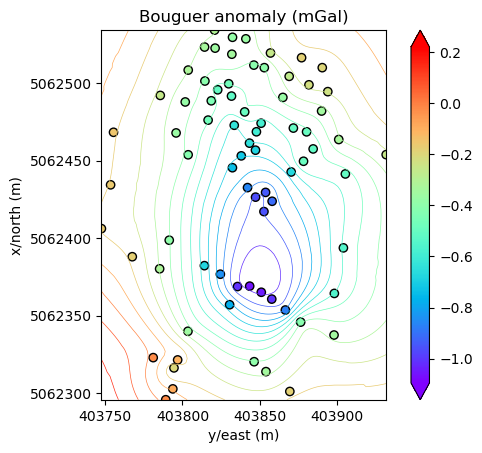

In [195]:
fig, ax = plt.subplots(1, 1)
vmin = np.min(data_i)
vmax = np.max(data_i)


# c = ax.contourf(Yi, Xi, data_i, levels=20, cmap="rainbow", vmin=vmin, vmax=vmax)
c = ax.contour(
    Yi,
    Xi,
    data_i,
    levels=20,
    linewidths=0.5,
    cmap="rainbow",
)
c = ax.scatter(
    ys,
    xs,
    # s=20,
    c=bouguer_gz2,
    cmap="rainbow",
    edgecolors="black",
    marker="o",
    vmin=vmin,
    vmax=vmax,
)
cbar = fig.colorbar(c, ax=ax, extend="both")
ax.ticklabel_format(style="plain", scilimits=(0, 10), useOffset=False)
ax.set_aspect("equal", "box")
ax.set_xlabel("y/east (m)")
ax.set_ylabel("x/north (m)")
ax.set_title("Bouguer anomaly (mGal)")

Text(0.5, 1.0, 'Bouguer anomaly (mGal)')

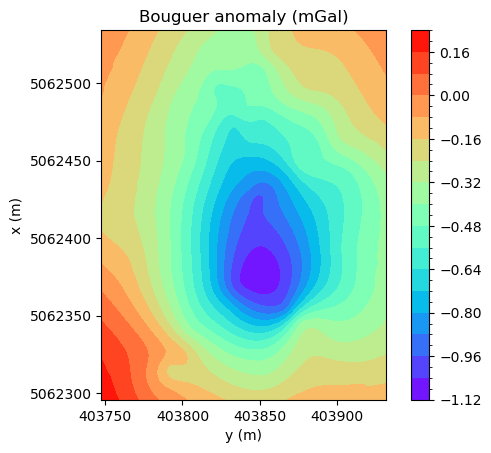

In [196]:
fig, ax = plt.subplots(1, 1)

c = ax.contourf(Yi, Xi, data_i, levels=20, cmap="rainbow")
cbar = fig.colorbar(c, ax=ax, extend="both")
ax.ticklabel_format(style="plain", scilimits=(0, 10), useOffset=False)
cbar.minorticks_on()
ax.set_aspect("equal", "box")
ax.set_xlabel("y (m)")
ax.set_ylabel("x (m)")
ax.set_title("Bouguer anomaly (mGal)")

(array([1., 0., 0., 2., 0., 1., 5., 1., 3., 1., 1., 2., 1., 0., 1., 0., 2.,
        5., 3., 0., 2., 3., 4., 2., 2., 1., 2., 0., 1., 4., 5., 0., 1., 1.,
        2., 1., 1., 2., 0., 1., 1., 1., 0., 1., 0., 1., 4., 1., 0., 2.]),
 array([-322.101 , -321.9603, -321.8196, -321.6789, -321.5382, -321.3975,
        -321.2568, -321.1161, -320.9754, -320.8347, -320.694 , -320.5533,
        -320.4126, -320.2719, -320.1312, -319.9905, -319.8498, -319.7091,
        -319.5684, -319.4277, -319.287 , -319.1463, -319.0056, -318.8649,
        -318.7242, -318.5835, -318.4428, -318.3021, -318.1614, -318.0207,
        -317.88  , -317.7393, -317.5986, -317.4579, -317.3172, -317.1765,
        -317.0358, -316.8951, -316.7544, -316.6137, -316.473 , -316.3323,
        -316.1916, -316.0509, -315.9102, -315.7695, -315.6288, -315.4881,
        -315.3474, -315.2067, -315.066 ]),
 <BarContainer object of 50 artists>)

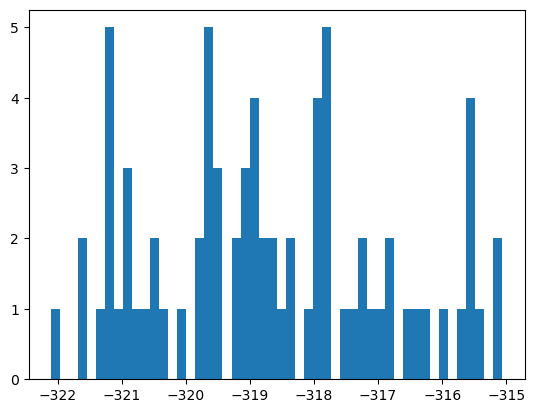

In [115]:
plt.hist(zs, bins=50)